In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]
    

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,5
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1


In [6]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,5
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,5
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,5
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,5
4,58.190871,43.667121,45.746463,42.343447,30.084076,48.247964,42.374778,39.387926,37.159804,49.153997,...,-0.151783,0.248175,14.496725,14.949878,3.585011,29.220897,3.871622,1,36,4


In [7]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,1
1,82.090071,66.576588,44.457472,43.406209,51.750090,33.061378,44.813918,43.999085,45.518410,41.850523,...,-0.012500,0.257141,9.483506,12.958784,4.558367,15.372567,2.792519,0,14,1
2,84.208982,62.966970,46.823424,37.631471,47.758099,42.029236,54.039877,44.406314,43.668848,47.363946,...,0.079334,0.517184,12.201532,11.095703,4.802391,15.916300,3.168262,0,14,1
3,70.073610,82.465856,47.496273,57.899457,57.234505,36.226570,59.486281,44.904293,37.335008,41.632832,...,0.297949,0.001637,9.933414,15.130064,4.932393,18.708356,3.396824,0,14,1
4,64.759162,101.448273,69.353902,61.032527,48.199999,48.181578,57.047702,46.993057,49.225614,39.971573,...,0.186153,0.195547,15.884816,10.161794,5.320202,13.979928,3.583472,0,14,1


In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import scipy

params = {
    'classify__n_estimators': range(5,100,1),
    'classify__criterion': ('gini', 'entropy'),
    'classify__max_depth': range(len(df.columns), 5 * len(df.columns)),
    'classify__max_features': ('log2', 'auto', None),
    'classify__oob_score': (True, False),
    'classify__warm_start': (True, False)
}

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90, score_func=chi2)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=20, solver='eigen')),
    ('classify', RandomForestClassifier(n_jobs=10, random_state=42))
])

randsrc = RandomizedSearchCV(
                clf,
                cv=10,
                refit=True,
                param_distributions = params,
                verbose=2,
                n_jobs=10,
                n_iter=100
)

randsrc.fit(train_X, train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   25.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  8.3min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 13.9min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7fa943d31378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...tors='warn', n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=10,
          param_distributions={'classify__max_depth': range(4, 20), 'classify__criterion': ('gini', 'entropy'), 'classify__oob_score': (True, False), 'classify__warm_start': (True, False), 'classify__n_estimators': range(5, 100), 'classify__max_features': ('log2', 'auto', None)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [10]:
sorted(randsrc.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__criterion',
 'param_classify__max_depth',
 'param_classify__max_features',
 'param_classify__n_estimators',
 'param_classify__oob_score',
 'param_classify__warm_start',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [11]:
randsrc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7fa943d31378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...estimators=43, n_jobs=10,
            oob_score=True, random_state=42, verbose=0, warm_start=True))])

0.684420393050413
Confusion matrix, without normalization
[[1069 1593]
 [ 623 3737]]


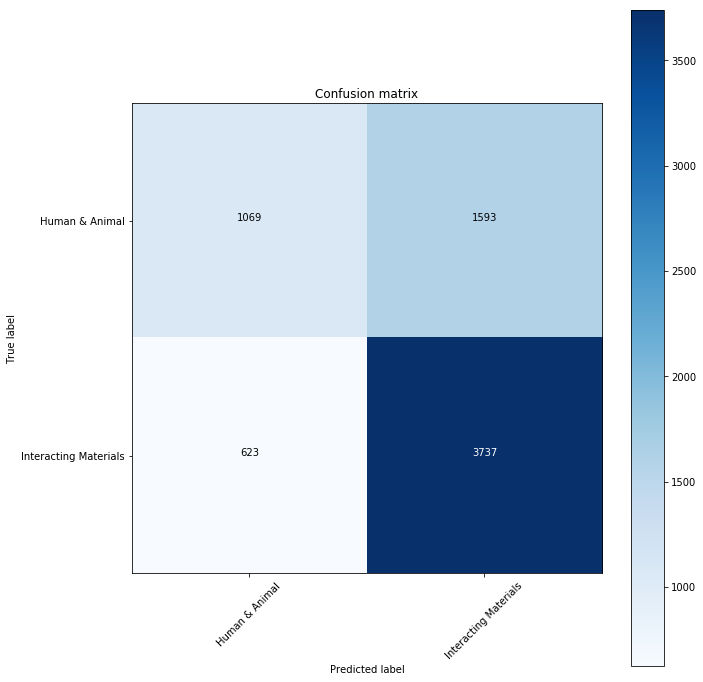

In [12]:
pred = randsrc.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [14]:
pred_prob = randsrc.predict_proba(test_X)

In [15]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for row, p, prob, Y in zip(test.iterrows(), pred, pred_prob, test_y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Actual target'].append(classes[int(row[1]['target'])])
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [16]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.595911,0.404089
Interacting Materials,0.323989,0.676011


In [17]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.592730,0.407270
breathing,0.328643,0.671357
brushing_teeth,0.728252,0.271748
can_opening,0.605286,0.394714
car_horn,0.558998,0.441002
cat,0.360712,0.639288
chainsaw,0.552590,0.447410
chirping_birds,0.297835,0.702165
church_bells,0.589173,0.410827


In [18]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.612923,0.387077
Interacting Materials,0.247803,0.752197


In [19]:
average_prob = correctly_classified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.272919,0.727081
breathing,0.610596,0.389404
brushing_teeth,0.164592,0.835408
can_opening,0.311216,0.688784
car_horn,0.304410,0.695590
cat,0.602826,0.397174
chainsaw,0.264283,0.735717
chirping_birds,0.580778,0.419222
church_bells,0.378728,0.621272


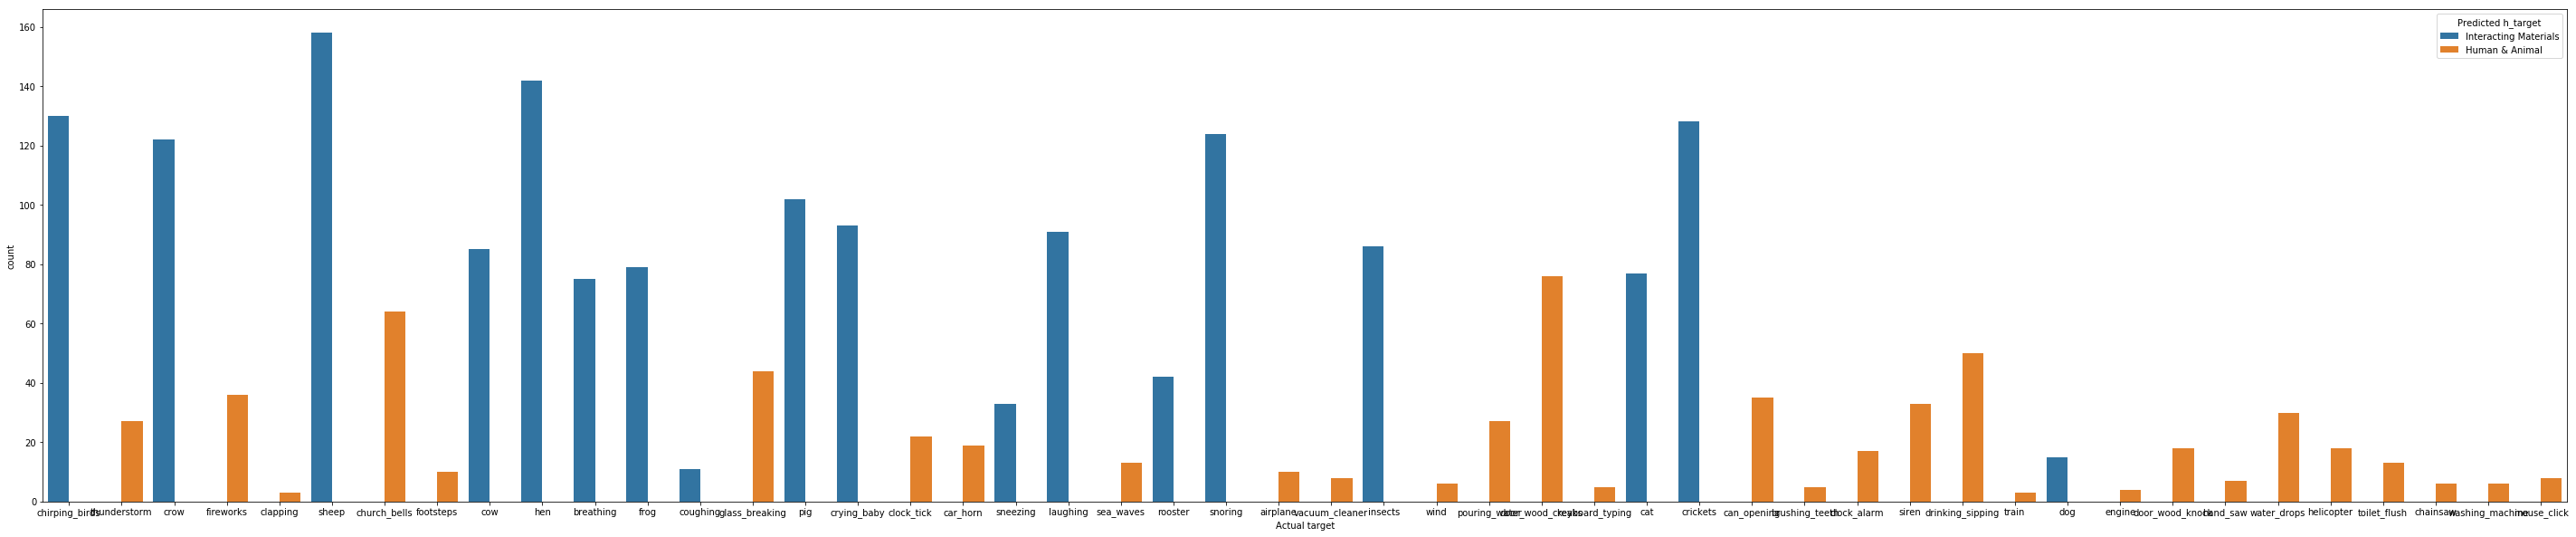

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)